# 读取文件

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from numpy import *
from sklearn.svm import LinearSVC

from datetime import datetime

from skimage.color import rgb2gray
from skimage.feature import hog

DATA_PATH = "D:/学习/课程资料/计算机视觉/cifar-10-python/cifar-10-batches-py/"

def unpack(fname):
    import pickle
    with open(fname, "rb") as fin:
        dumped = pickle.load(fin, encoding="bytes")
    return dumped

def reshape(data):
    img = np.zeros((32, 32, 3), 'uint8')
    img[..., 0] = np.reshape(data[:1024], (32, 32))
    img[..., 1] = np.reshape(data[1024:2048], (32, 32))
    img[..., 2] = np.reshape(data[2048:3072], (32, 32))
    return img

N = 5
test_num = 10000
bestLoss = 100000
bestWeights = 0
loss = []

batches_meta = unpack(DATA_PATH + "batches.meta")
data_batches = [
    unpack(DATA_PATH + "data_batch_" + str(i+1))
    for i in range(5)
]
test_batch = unpack(DATA_PATH + "test_batch")

# 融合

In [7]:
# 将图片转换成灰度图并提取出边缘特征
for i in range(N):
    data_batches[i][b"data"] = [hog(rgb2gray(reshape(img))) for img in data_batches[i][b"data"]]

# 将所有的图片汇总起来放到一个对象里，每个元素为一个数组，分别为hog值与分类
data_all = {}
labels = []
hogs = []
for i in range(N):
      for j in range(10000):
            hogs.append(data_batches[i][b"data"][j])
            labels.append(data_batches[i][b"labels"][j])
data_all['labels'] = labels
data_all['data'] = hogs

test_batch[b"data"] = [hog(rgb2gray(reshape(img))) for img in test_batch[b"data"]]

# 将所有的测试图片汇总起来放到一个对象里，每个元素为一个数组，分别为hog值与分类
test_all = {}
labels = []
hogs = []

for i in range(test_num):
      hogs.append(test_batch[b"data"][i])
      labels.append(test_batch[b"labels"][i])
test_all['labels'] = labels
test_all['data'] = hogs

D:\Anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


# 产生W随机矩阵

In [8]:
W = np.random.random((10,324))
W = mat(W)

# 设置步长开始训练

loss is 247.5992061099974
loss is 248.8710907352129
loss is 246.98213434417258
loss is 246.51628170329033
loss is 247.21775223207234
loss is 244.6037500277262
loss is 245.73318346140596
loss is 244.0015923410047
loss is 242.2885472613027
loss is 242.49716456810202
loss is 244.71373861130684
loss is 242.1155333939568
loss is 240.19743878132502
loss is 242.5868226973495
loss is 238.12597005216136
loss is 238.2835448286767
loss is 238.04792751621684
loss is 241.9868164278161
loss is 239.5762074864191
loss is 236.90209076412324
loss is 235.341715348287
loss is 238.61861168755766
loss is 237.4399005623657
loss is 238.74329255092957
loss is 237.62417670661046
loss is 233.55663518233132
loss is 231.06137196246166
loss is 236.51535327232423
loss is 236.41725803544227
loss is 231.90178354581872
loss is 233.43792518526666
loss is 233.01844575596888
loss is 234.76185751065137
loss is 230.76652138562554
loss is 231.87139605364823
loss is 230.02296015206133
loss is 231.43659576674008
loss is 231.98

ValueError: x and y must have same first dimension, but have shapes (100,) and (120,)

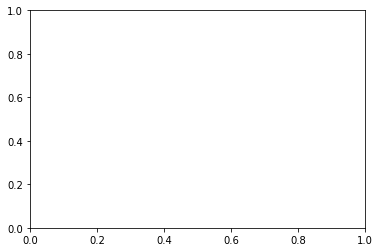

In [11]:
#计算梯度
def evaluate_gradient(f, x, W):
  global bestWeights
  global bestLoss
  global loss
  xmatrics = mat(x["data"])
  matrics = W*xmatrics.T
  fx = f(matrics, x["labels"]) # evaluate function value at original point
  if (fx < bestLoss):
      bestWeights = W
      bestLoss = fx
  loss.append(fx)
#   ks = linspace(1,1000,1000)
#   plt.plot(ks, loss)
  print("loss is", fx)
  grad = np.zeros(W.shape)
  h = 0.0001
  [idx, idy] = W.shape

  for i in range(idx):
        for j in range(idy):
            # evaluate function at x+h
            ix = i
            iy = j
            old_value = W[ix, iy]
            W[ix, iy] = old_value + h # increment by h
            matrics = W*xmatrics.T
            fxh = f(matrics, x["labels"]) # evalute f(x + h)
            W[ix, iy] = old_value # restore to previous value (very important!)

            # compute the partial derivative
            grad[ix, iy] = (fxh - fx) / h # the slope
            # W += - 0.1 * mat(grad)
  return mat(grad)

#定义softmax 损失函数
def loss_fun(data, labelList):
    [x, y] = data.shape
    L = 0
    for i in range(0, y):
          sum = 0
          for j in range(0, x):
                sum += math.exp(data[j, i])
          L += -math.log10(math.exp(data[labelList[i], i]) / sum)
    return L

#进行图片采样
def pics_sample(data, num):
      res = {}
      labelList = []
      dataList = []
      for i in range(0, num):
            randomNum = random.randint(0, 10000 * N)
            randomData = data["data"][randomNum]
            randomLabel = data["labels"][randomNum]
            labelList.append(randomLabel)
            dataList.append(randomData)
      res['data'] = dataList
      res['labels'] = labelList
      return res

#设置步长
step_size = 0.2
i = 100
times = linspace(1,i,i)

while i > 0:
      # 图片采样
      data = pics_sample(data_all, 256)
      # 计算梯度
      weights_grad = evaluate_gradient(loss_fun, data, W)
      # 更新梯度
      W += - step_size * weights_grad  
      i = i - 1

pltloss = loss[20:120]

best loss 213.15576116277174


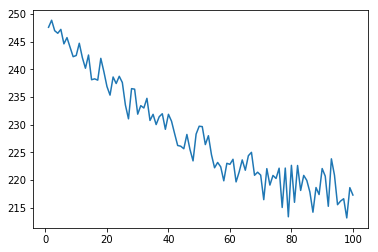

In [29]:
print ("best loss", bestLoss)
plt.plot(times,pltloss)

# 检查正确率

In [12]:
right_num = 0
test_matrix = mat(test_all["data"])
test_result = bestWeights * test_matrix.T
for j in range(10000):
      biggest_num = -10000
      result_label = 10
      for i in range(10):
            if (biggest_num < test_result[i, j]):
                  biggest_num = test_result[i, j]
                  result_label = i
      if (result_label == test_all["labels"][j]):
            right_num += 1
print("right rate", right_num/10000)

right rate 0.3997
